In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
import gc
import seaborn as sns

plt.style.use('ggplot')

import os
for dirname,_, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
DEBUG_MODE = False

CROPS = ("maize", "wheat")

MODES = ('train', 'test')

FEATURES_TEMPORAL = {
    # Time series data -- 240 columns reflecting daily values for 30 days before sowing and 210 days after.
    'tas',       # Mean daily temperature
    'tasmax',    # Max daily temperature
    'tasmin',    # Min daily temperature
    'pr',        # precipitation
    'rsds'      # shortwave radiation
}

FEATURES_STATIC = {
    # Static data
    'soil_co2',  # crop, year, lon, lat, texture_class, real_year, co2, nitrogen
    # dominant USDA soil texture class (constant over time), the ambient CO2 concentration (spatially constant), the planting date and the nitrogen application rate (constant over time)
}

FEATURES = set.union(FEATURES_TEMPORAL, FEATURES_STATIC)

COLUMNS_TO_DROP = ['crop','variable']

# Sowing date
INDEX_SOW = 30  # days
# Time series data length
SEASON_LENGTH = 240  # days
# Nr. of soil texture classes
NUM_TEXTURE_CLASSES = 13  

YEAR_TRAIN_MIN = 1982
YEAR_TRAIN_MAX = 2020  # Inclusive
YEAR_TEST_MIN = 2021
YEAR_TEST_MAX = 2098

PATH_INPUT = os.path.abspath(os.path.join(os.sep, 'kaggle', 'input', 'the-future-crop-challenge'))
# PATH_INPUT = os.path.abspath(os.path.join(os.getcwd(), 'data'))  # For running the notebook locally

In [5]:
# Reduce memory usage of a pandas DataFrame
def reduce_memory_usage(df):
    """Reduce memory usage of a pandas DataFrame."""
    # Function to iterate through columns and modify the data types
    start_mem = df.memory_usage().sum() / 1024**2
    #print(f"Memory usage of dataframe: {start_mem} MB")

    for col in df.columns:
        if col in df.index.names:  # Skip index columns, since other formats of index aren't supported by the engine
            continue

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)  # Keep sufficient precision
            else:
                if col == "year":  # Ensure precision for grouping columns
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    #print(f"Memory usage after optimization: {end_mem} MB")
    #print(f"Decreased by {100 * (start_mem - end_mem) / start_mem}%")
    return df

In [6]:
def load_data(crop: str, # Which crop
              mode: str, # Which dataset (i.e. train/test)
              select_only_features: bool = True, # Drop every other column (crop, year, lon, lat) if not relevant for computation
              take_subset: bool = False,  # If set to true, take a small subset of the data (for debugging purposes)
             ) -> dict:
    assert crop in CROPS
    assert mode in MODES
    
    output = dict()
    
    for f in FEATURES:
        path = os.path.join(PATH_INPUT, f'{f}_{crop}_{mode}.parquet')
        df = reduce_memory_usage(pd.read_parquet(path))

        columns_to_drop_in_df = [col for col in COLUMNS_TO_DROP if col in df.columns] 
        if columns_to_drop_in_df:
            df = df.drop(columns=columns_to_drop_in_df)

        if select_only_features:
            if f in FEATURES_TEMPORAL:  # Select only the time series data -- drop other columns
                df = df[[str(i) for i in range(SEASON_LENGTH)]]
        
        output[f] = df

        # Free up memory after processing each file
        del df  # Explicitly delete the DataFrame
        gc.collect()  # Force garbage collection
        
    if mode == 'train':
        output['target'] = pd.read_parquet(os.path.join(PATH_INPUT, f'{mode}_solutions_{crop}.parquet'))
    
    # If required, only take a subset of the data for debugging purposes -- we don't really care which samples
    if take_subset:
        num_select = 100  # Take only 100 samples from the dataset
        # Select which samples based on the index of some feature
        ixs_selected = output[tuple(FEATURES)[0]].index[:num_select]
        # Filter all dataframes
        output = {
            key: df.loc[ixs_selected] for key, df in output.items()
        }
   
    return output

In [7]:
# Load all available data for all crops
crop_data_train = {
    crop: load_data(crop, 'train', take_subset=DEBUG_MODE, select_only_features=False) for crop in CROPS
}


crop_data_test = {
    crop: load_data(crop, 'test', take_subset=DEBUG_MODE, select_only_features=False) for crop in CROPS
}

# Separate data in features and targets
crop_features_train = {
    crop: {
        k: v for k, v in data.items() if k in FEATURES
    } for crop, data in crop_data_train.items()
}
crop_features_test = {
    crop: {
        k: v for k, v in data.items() if k in FEATURES
    } for crop, data in crop_data_test.items()
}

crop_targets_train = {
    crop: data['target'] for crop, data in crop_data_train.items()
}

In [ ]:
yield_maize_df = pd.DataFrame(crop_targets_train['maize'])
yield_wheat_df = pd.DataFrame(crop_targets_train['wheat'])

In [ ]:
maize_tasmin_df = pd.DataFrame(crop_data_train['maize']['tasmin'])

print(crop_data_train['maize'])

columns_to_use = ['year'] + [str(i) for i in range(240)]

filtered_df = maize_tasmin_df[columns_to_use]

averaged_tasmin = filtered_df.groupby('year').mean()

print(averaged_tasmin)

## Evaluating **Average Yield** per Year(1982-2020) on both Crops

In [10]:
columns_to_use = ['year']

y_maize_df = pd.DataFrame(crop_data_train['maize']['pr'])[columns_to_use]
y_wheat_df = pd.DataFrame(crop_data_train['wheat']['pr'])[columns_to_use]

merged_maize_yield_df = y_maize_df.merge(yield_maize_df, on='ID')
merged_wheat_yield_df = y_wheat_df.merge(yield_wheat_df, on='ID')

mean_yield_maize = merged_maize_yield_df.groupby('year')['yield'].mean()
mean_yield_wheat = merged_wheat_yield_df.groupby('year')['yield'].mean()

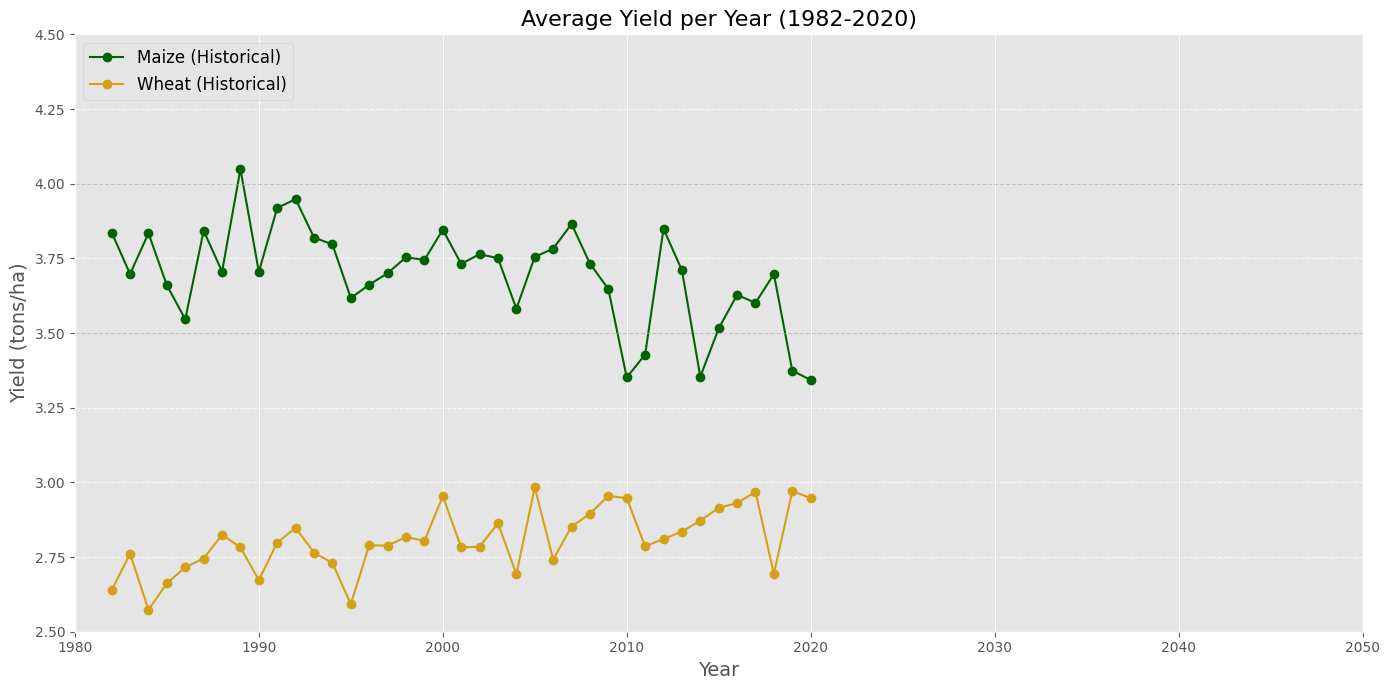

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Extend years to 2050
numeric_years = mean_yield_maize.index  # Original year format (e.g., 319, 380)
mapped_years = 1982 + (numeric_years - min(numeric_years))  # Map to actual years
future_years = np.arange(2021, 2051)  # Future years

# Create placeholders for future yields (e.g., use NaN or extrapolation methods later)
future_yield_maize = np.full(len(future_years), np.nan)
future_yield_wheat = np.full(len(future_years), np.nan)

# Combine historical and future data
future_yield_maize = np.full(len(future_years), np.nan)
future_yield_wheat = np.full(len(future_years), np.nan)

all_years = np.concatenate([mapped_years, future_years])
all_yield_maize = np.concatenate([mean_yield_maize.values, future_yield_maize])
all_yield_wheat = np.concatenate([mean_yield_wheat.values, future_yield_wheat])

# Plotting
plt.figure(figsize=(14, 7))

# Historical plot for maize
plt.plot(mapped_years, mean_yield_maize.values, label="Maize (Historical)", 
         color="#006400", marker="o")  # Dark Green from Palette 1

# Historical plot for wheat
plt.plot(mapped_years, mean_yield_wheat.values, label="Wheat (Historical)", 
         color="#D4A017", marker="o")  # Golden Wheat from Palette 1

# Add horizontal threshold lines
thresholds = [3.5, 4.0, 4.5]
for threshold in thresholds:
    plt.axhline(y=threshold, color="#A9A9A9", linestyle="--", linewidth=0.8, alpha=0.7)  # Neutral gray

# Title and labels
plt.title("Average Yield per Year (1982-2020)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Yield (tons/ha)", fontsize=14)
plt.ylim(2.5, 4.5)  # Range on y-axis
plt.xlim(1980, 2050)  # Explicitly set x-axis range

# Grid, legend, and style
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(fontsize=12, loc="upper left")

plt.tight_layout()
plt.show()


## Scatter Plot of Yield vs. Average Daily Temperature (tas)

/tmp/ipykernel_30/2681890771.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tas_maize_data['mean_tas'] = tas_maize_data.iloc[:, 6:246].mean(axis=1)  # Columns 6-245 are daily temps
/tmp/ipykernel_30/2681890771.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tas_maize_data.reset_index(inplace=True)


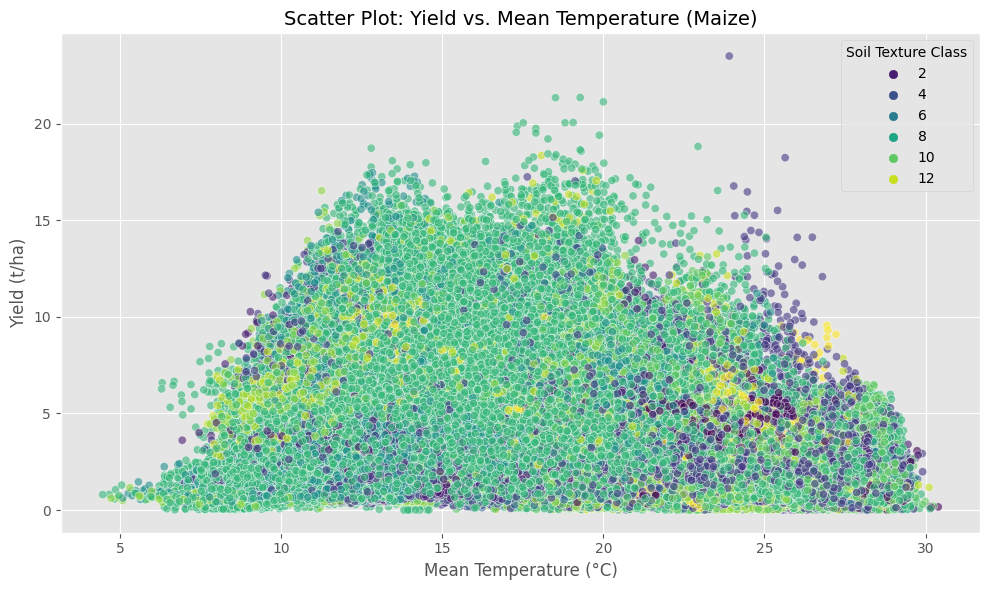

In [12]:
# Assuming yield_maize_df is already defined
soil_maize_data = pd.DataFrame(crop_data_train['maize']['soil_co2'])  # Soil and CO2 data
tas_maize_data = pd.DataFrame(crop_data_train['maize']['tas'])  # Daily mean temperature

# Preprocess the temperature data
tas_maize_data['mean_tas'] = tas_maize_data.iloc[:, 6:246].mean(axis=1)  # Columns 6-245 are daily temps

# Reset index to ensure 'ID' is a column
tas_maize_data.reset_index(inplace=True)

# Merge dataframes using 'ID' as a column
merged_data = yield_maize_df.merge(soil_maize_data, on='ID').merge(tas_maize_data[['ID', 'mean_tas']], on='ID')

# Scatter plot of yield vs. average temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='mean_tas', y='yield', hue='texture_class', alpha=0.6, palette='viridis')
plt.title("Scatter Plot: Yield vs. Mean Temperature (Maize)", fontsize=14)
plt.xlabel("Mean Temperature (°C)", fontsize=12)
plt.ylabel("Yield (t/ha)", fontsize=12)
plt.grid(True)
plt.legend(title='Soil Texture Class', loc='upper right')
plt.tight_layout()
plt.show()

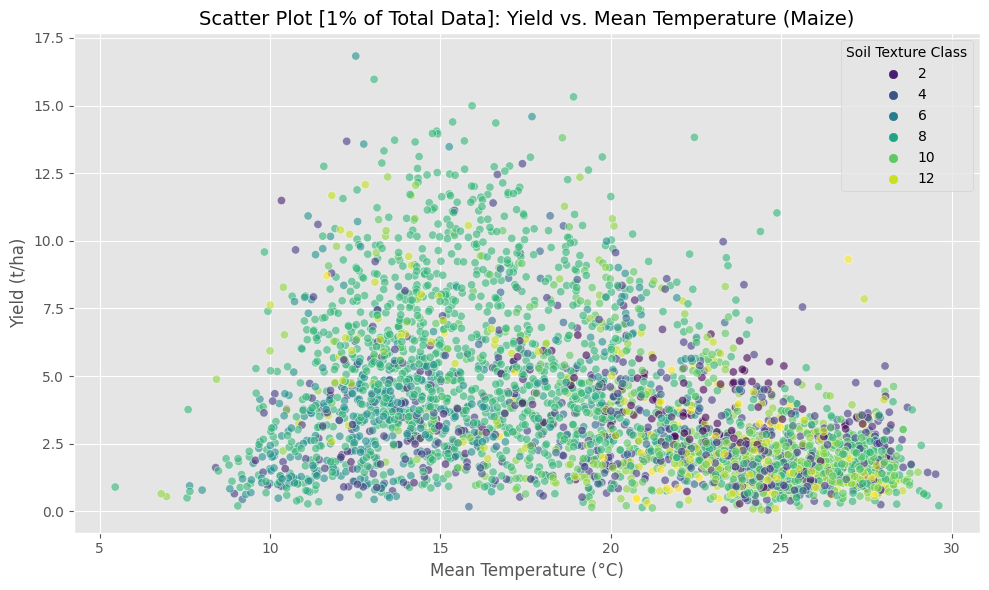

In [13]:
# Sample a subset of the data (e.g., 1% of the data)
sampled_data = merged_data.sample(frac=0.01, random_state=42)

# Scatter plot using the sampled data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sampled_data, x='mean_tas', y='yield', hue='texture_class', alpha=0.6, palette='viridis')
plt.title("Scatter Plot [1% of Total Data]: Yield vs. Mean Temperature (Maize)", fontsize=14)
plt.xlabel("Mean Temperature (°C)", fontsize=12)
plt.ylabel("Yield (t/ha)", fontsize=12)
plt.grid(True)
plt.legend(title='Soil Texture Class', loc='upper right')
plt.tight_layout()
plt.show()

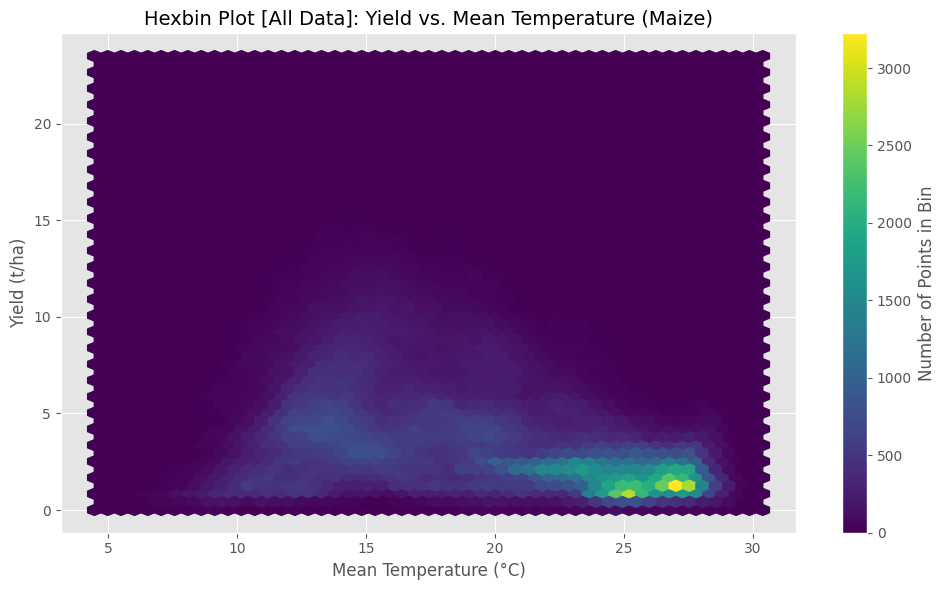

In [14]:
plt.figure(figsize=(10, 6))
plt.hexbin(merged_data['mean_tas'], merged_data['yield'], gridsize=50, cmap='viridis')
plt.colorbar(label='Number of Points in Bin')
plt.title("Hexbin Plot [All Data]: Yield vs. Mean Temperature (Maize)", fontsize=14)
plt.xlabel("Mean Temperature (°C)", fontsize=12)
plt.ylabel("Yield (t/ha)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

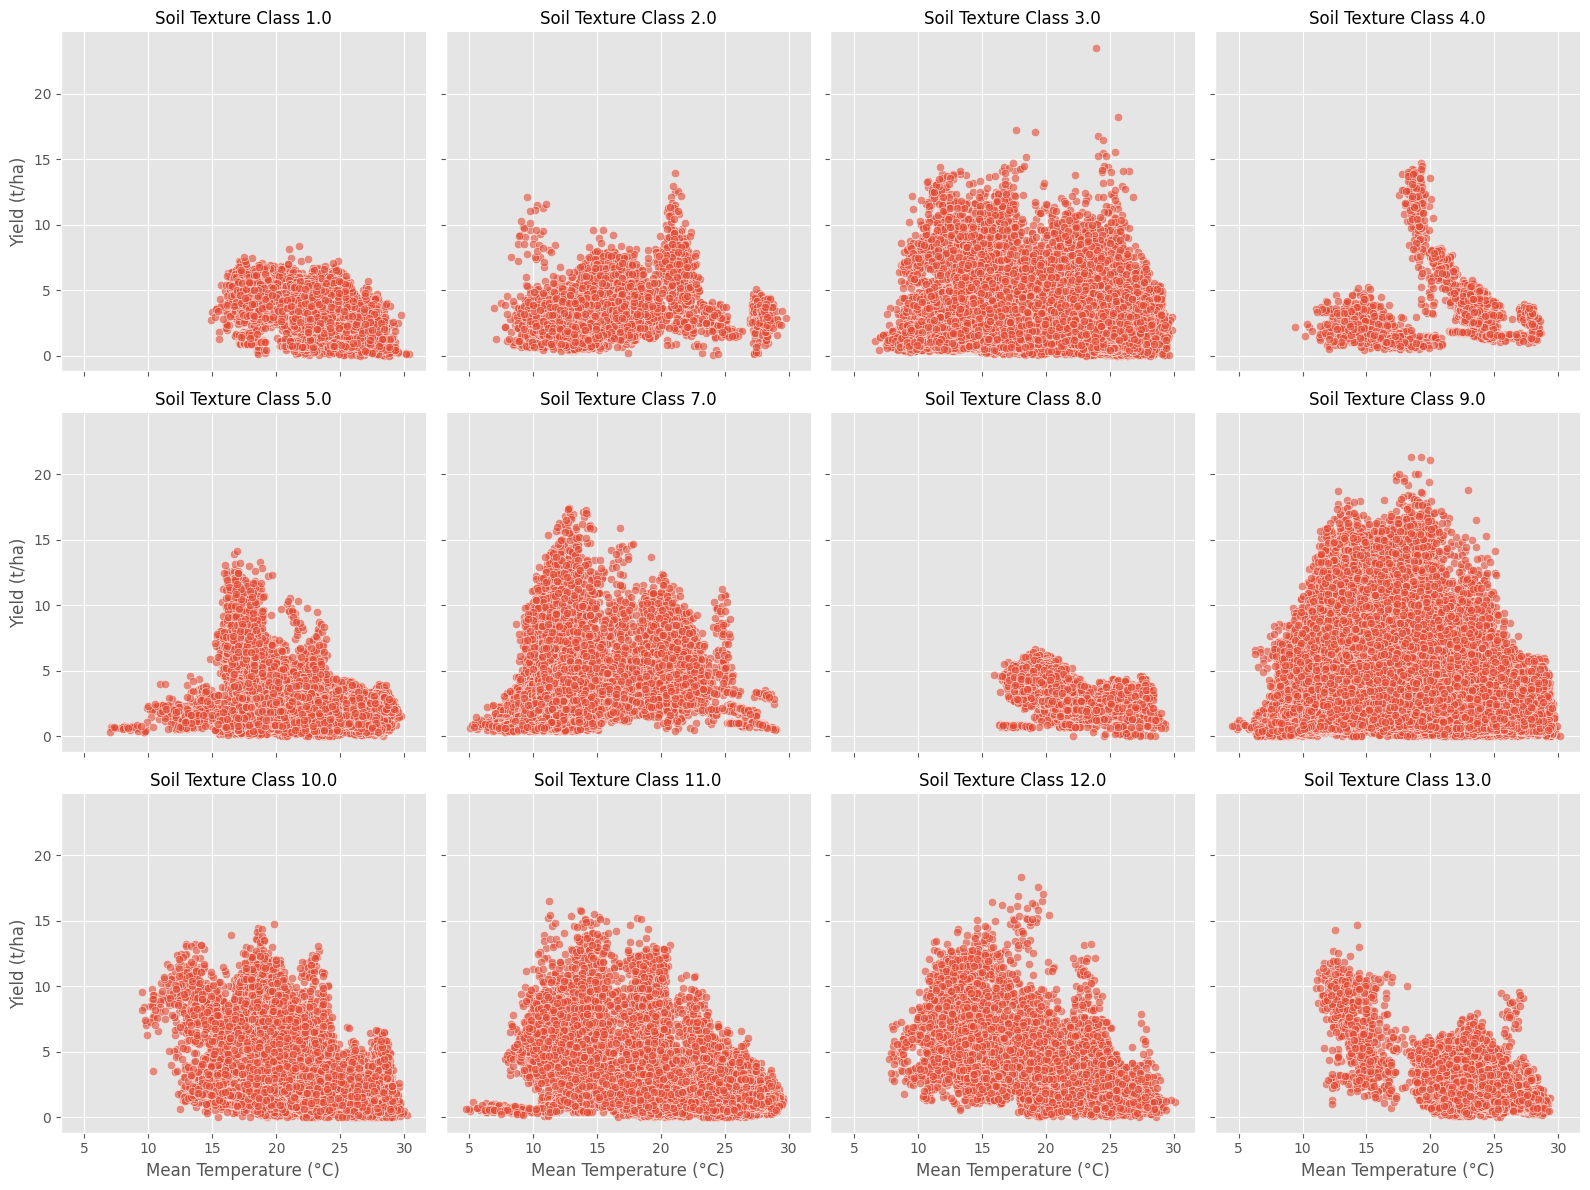

In [16]:
# FacetGrid by 'texture_class'
g = sns.FacetGrid(merged_data, col="texture_class", col_wrap=4, height=4)
g.map(sns.scatterplot, 'mean_tas', 'yield', alpha=0.6)
g.set_axis_labels("Mean Temperature (°C)", "Yield (t/ha)")
g.set_titles("Soil Texture Class {col_name}")
g.tight_layout()
plt.show()

## Daily Average Values of Temperatures by Decades

/tmp/ipykernel_30/3812951068.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('coolwarm', len(decade_averages.columns))


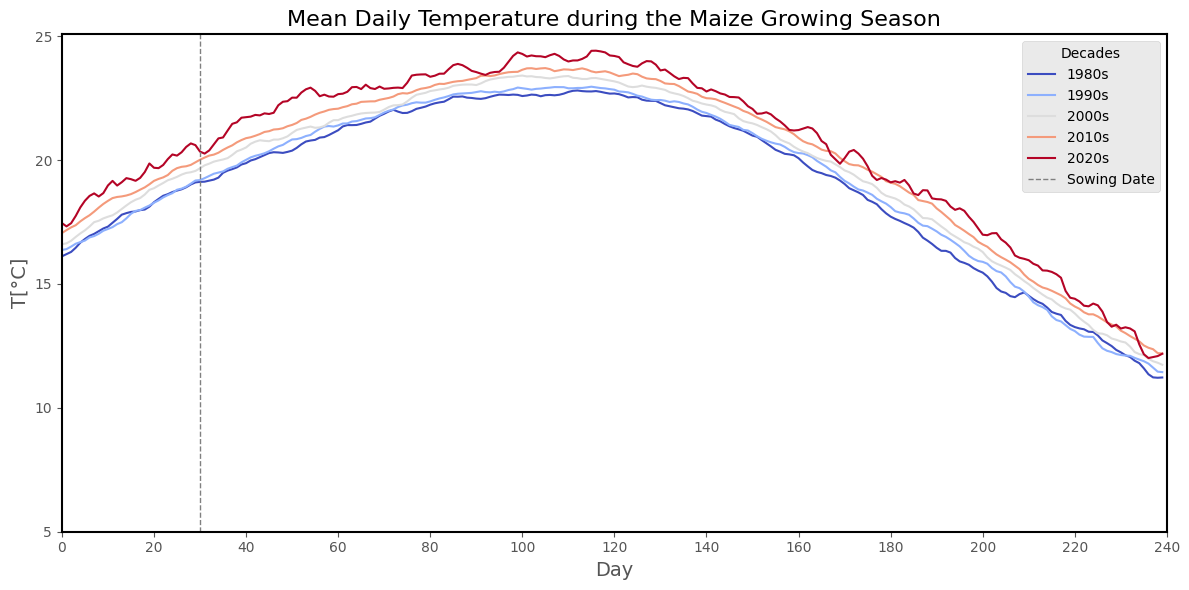

In [35]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

# Replace with actual mean temperature data
transposed_tas = crop_data_train['maize']['tas'].groupby('year').mean().T  
OFFSET_YEARS = 1601

# Add offset and compute decades
decade_mapping = (transposed_tas.columns + OFFSET_YEARS) // 10 * 10

# Create a DataFrame grouped by decades
grouped_data = transposed_tas.T.groupby(decade_mapping).mean()

# Transpose back to original orientation
decade_averages = grouped_data.T

# Set up colormap
colormap = cm.get_cmap('coolwarm', len(decade_averages.columns))

# Plotting
plt.figure(figsize=(12, 6))

for i, decade in enumerate(decade_averages.columns):
    plt.plot(
        decade_averages.index,
        decade_averages[decade],
        label=f"{int(decade)}s",
        linewidth=1.5,
        color=colormap(i)
    )
    
# Sowing date vertical line
plt.axvline(x=30, color="gray", linestyle="--", linewidth=1, label="Sowing Date")

# Configure aesthetics
plt.title("Mean Daily Temperature during the Maize Growing Season", fontsize=16)
plt.xlabel("Day", fontsize=14)
plt.ylabel("T[°C]", fontsize=14)
plt.xticks(ticks=range(0, 241, 20), labels=[str(day) for day in range(0, 241, 20)])
plt.yticks(ticks=range(5, 30, 5), labels=range(5, 30, 5))
plt.xlim(0, 240)
plt.legend(title="Decades", loc="upper right", fontsize=10)

ax = plt.gca()
ax.set_facecolor("white")  # Ensure white background
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # Set spine color to black
    spine.set_linewidth(1.5)      # Set spine thickness

plt.tight_layout()
plt.show()


## Possibly Extracting Correlation Between Variables [Maize]

In [19]:
maize_features_train = crop_features_train['maize']

# Define a sampling rate or the number of rows to sample
SAMPLE_SIZE = 100000

# Determine common indices across all temporal features
common_indices = maize_features_train[next(iter(FEATURES_TEMPORAL))].sample(
    n=SAMPLE_SIZE, random_state=42
).index

# Sample and rename temporal features
sampled_temporal_features = [
    maize_features_train[feature].loc[common_indices].rename(
        columns=lambda x: f"{feature}_{x}"  # Rename columns with feature prefix
    )
    for feature in FEATURES_TEMPORAL
]

static_data_numeric = maize_features_train['soil_co2'].loc[common_indices]

yield_maize_df = crop_targets_train['maize'].loc[common_indices]

# Concatenate sampled temporal features and static data
maize_data_combined = pd.concat(sampled_temporal_features + [static_data_numeric, yield_maize_df], axis=1)

In [20]:
# Aggregating temporal features (mean, std, max, min) for each temporal feature
aggregated_temporal_features = []

for feature in FEATURES_TEMPORAL:
    # Identify columns corresponding to the current feature
    temporal_cols = [col for col in maize_data_combined.columns if col.startswith(feature)]
    if temporal_cols:  # Check if the feature has matching columns
        # Extract relevant subset of columns for the current feature
        temporal_subset = maize_data_combined[temporal_cols]
        
        # Compute aggregates
        temporal_aggregates = pd.DataFrame({
            f"{feature}_mean": temporal_subset.mean(axis=1),
            f"{feature}_std": temporal_subset.std(axis=1),
            f"{feature}_max": temporal_subset.max(axis=1),
            f"{feature}_min": temporal_subset.min(axis=1),
        })
        aggregated_temporal_features.append(temporal_aggregates)
    else:
        print(f"No temporal columns found for feature: {feature}")

# Combine all aggregated temporal features into one DataFrame
if aggregated_temporal_features:
    temporal_aggregates_df = pd.concat(aggregated_temporal_features, axis=1)
else:
    raise ValueError("No temporal features were aggregated. Check column names and FEATURES_TEMPORAL.")

In [21]:
combined_data = pd.concat([temporal_aggregates_df, static_data_numeric, yield_maize_df], axis=1).drop(columns=["year"])

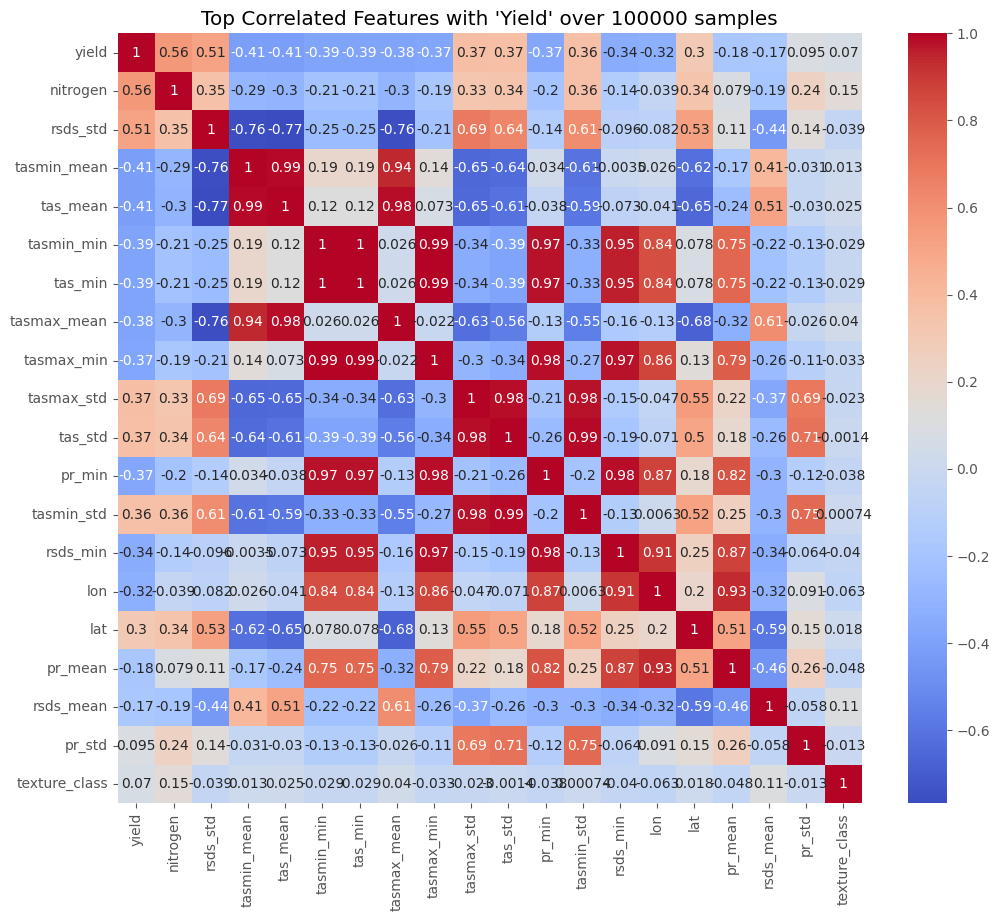

In [22]:
import seaborn as sns

# Compute correlation matrix
correlation_matrix = combined_data.corr()

# Select top correlated features with 'yield' (if available)
if 'yield' in combined_data.columns:
    top_features = correlation_matrix['yield'].abs().nlargest(20).index
    reduced_correlation_matrix = correlation_matrix.loc[top_features, top_features]

    # Plot heatmap of top correlated features with 'yield'
    plt.figure(figsize=(12, 10))
    sns.heatmap(reduced_correlation_matrix, annot=True, cmap="coolwarm")
    plt.title("Top Correlated Features with 'Yield' over " + str(SAMPLE_SIZE) + " samples")
    plt.show()
else:
    print("No 'yield' column found in the data. Please check your input data.")